# **Modelo de Regresión de Clusters**
---

In [183]:
import pandas as pd

import sys
sys.path.append("../..")

from src.support_prep import *
from src.support_eda import plot_col
from src.support_reg import *
from src.support_test_stats import *

In [184]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
df = pd.read_pickle("../../datos/clean.pkl")
clusters = pd.read_pickle("../../datos/clusters.pkl")

In [186]:
cluster0 = (clusters == 0)
df_cluster0 = df[cluster0]
df_cluster0.reset_index(drop=True, inplace=True)

cluster1 = (clusters == 1)
df_cluster1 = df[cluster1]
df_cluster1.reset_index(drop=True, inplace=True)

In [187]:
df_cluster0.drop(columns = ["order_date", "ship_date"], inplace=True)
df_cluster1.drop(columns = ["order_date", "ship_date"], inplace=True)

## EDA comparativo

In [188]:
display(df_cluster0.describe().T)
display(df_cluster1.describe().T)

,count,mean,std,min,25%,50%,75%,max
sales,49137.0,179.358958,288.080510,0.444,29.400,78.312,215.88,22638.48
quantity,49137.0,3.384273,2.220542,1.000,2.000,3.000,4.00,14.00
discount,49137.0,0.147390,0.215221,0.000,0.000,0.000,0.20,0.85
profit,49137.0,8.637032,114.298828,-6599.978,-0.189,8.274,30.70,358.56
shipping_cost,49137.0,18.525557,31.275969,0.000,2.480,7.160,20.85,865.74


,count,mean,std,min,25%,50%,75%,max
sales,2153.0,1778.606951,1148.631580,504.0000,1060.800,1473.1000,2125.320,17499.950
quantity,2153.0,5.582443,2.558390,1.0000,4.000,5.0000,7.000,14.000
discount,2153.0,0.040609,0.073814,0.0000,0.000,0.0000,0.100,0.470
profit,2153.0,484.467939,457.275428,-452.8104,275.583,374.3792,572.925,8399.976
shipping_cost,2153.0,205.541301,149.617988,2.3400,100.920,164.9200,262.660,933.570


Vemos que los clusters tienen la mayor diferencia en los beneficios, como se estudió durante la clusterización.

<Axes: title={'center': 'Cluster 1'}>

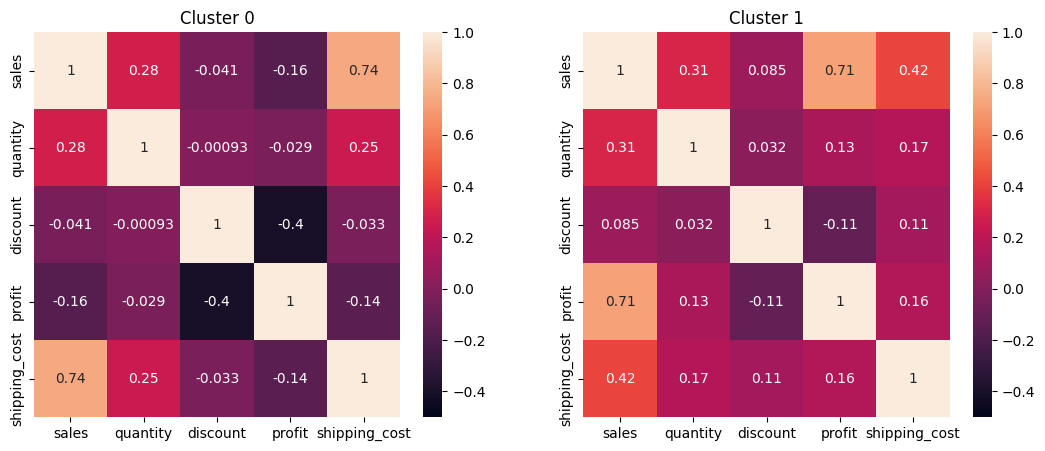

In [189]:
plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
plt.title("Cluster 0")
sns.heatmap(df_cluster0.select_dtypes("number").corr(), annot=True, vmin = -0.5)
plt.subplot(1, 2, 2)
plt.title("Cluster 1")
sns.heatmap(df_cluster1.select_dtypes("number").corr(), annot=True, vmin = -0.5)

Comparando las correlaciones entre variables en los dos clusters, vemos varias diferencias:
- Cluster 0:
    - Alta correlación de `sales` y `shipping_cost`, lo que indica que las ventas tienden a estar asociadas a mayores costos de envío.
    - Correlación negativa moderada entre `profit` y `discount`, lo cual indica que los descuentos tienen un impacto negativo en los beneficios generados en las transacciones.
    - Correlación negativa entre `profit` y `shipping_cost`, lo que indica que hay espacio de mejora en la optimización logística, ya que el costo de envío está afectando negativamente a los beneficios para este grupo.
- Cluster 1:
    - Alta correlación de `sales` y `profit`, lo que indica que en este grupo las ventas directamente afectan a los beneficios generados, lo cual podría ser indicativo de que el resto de factores están bien optimizados.
    - Baja correlación negativa entre `profit` y `discount`, lo cual indica que para este grupo los descuentos no penalizan tanto en los beneficios generados.
    - Correlación positiva entre `profit` y `shipping_cost`, indicativo de que la logística está más optimizada en este grupo.

In [190]:
def plot_contingency_clusters(data, clusters, category):
    contingency_table = pd.crosstab(clusters, data[category])
    contingency_table_normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    sns.heatmap(contingency_table_normalized, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f"Proporción de {category} por Cluster")
    plt.xlabel(category)
    plt.ylabel("Cluster")
    plt.show()


In [191]:
cat_cols = df.select_dtypes("O").columns

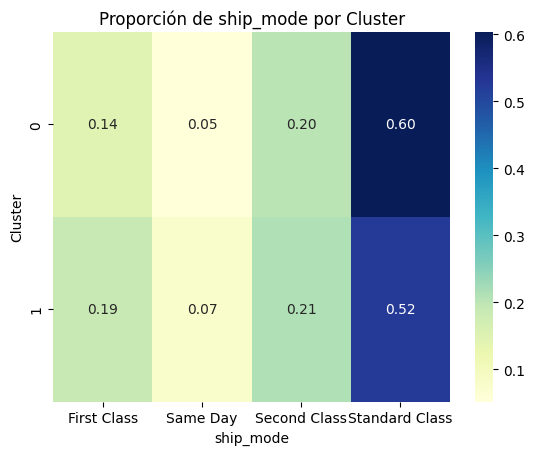

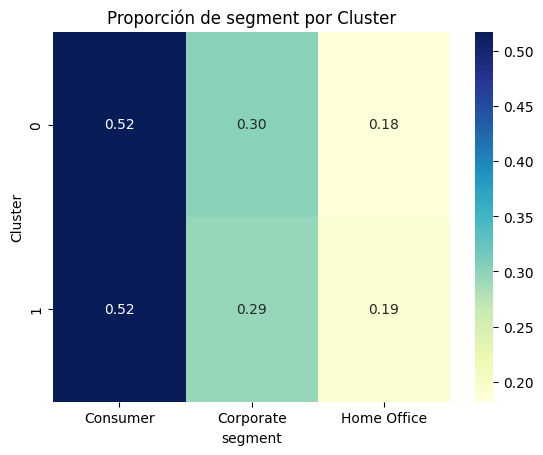

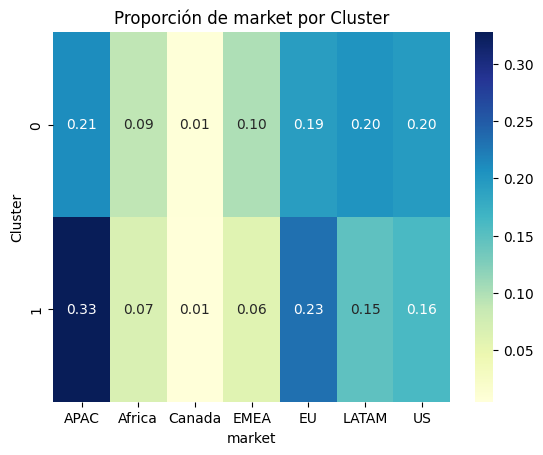

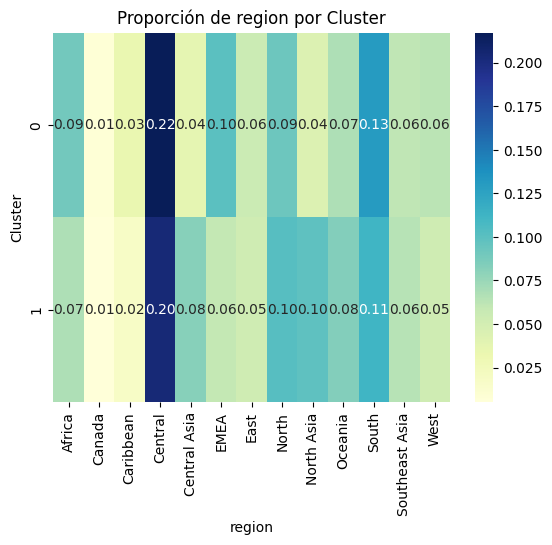

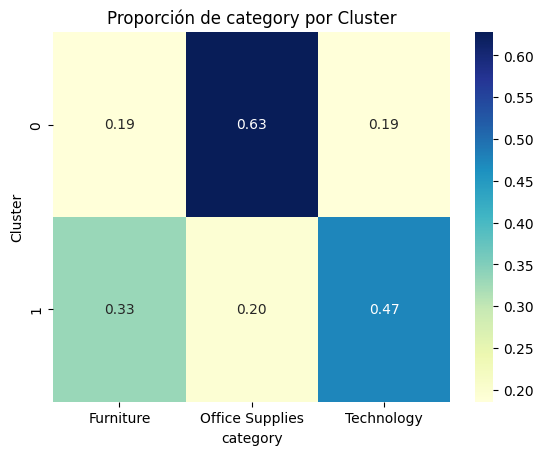

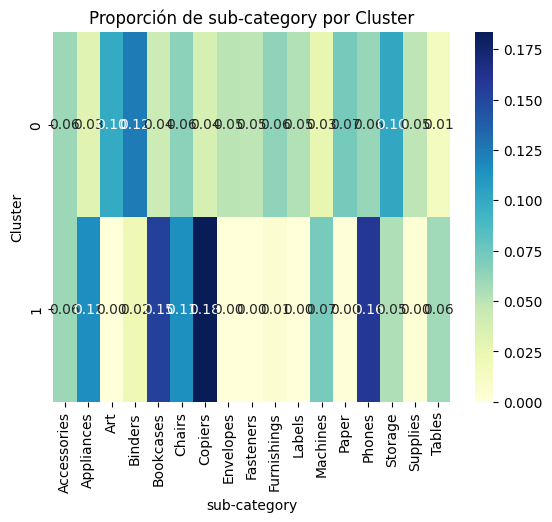

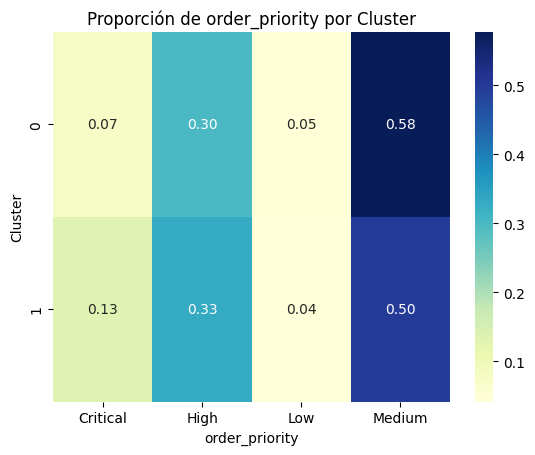

In [192]:
for col in cat_cols.drop("country"):
    plot_contingency_clusters(data = df, clusters=clusters, category=col)

Vemos que en las categóricas las diferencias claves están en los productos: la categoría y subcategoría de estos. En el cluster 0 vemos principalmente ventas de productos de oficina, mientras que en el cluster 1 vemos una preferencia en tecnología, lo cual indica que estos últimos son los producto de los cuales más rentabilidad se extrae.

Antes de proceder al preprocesamiento, eliminaremos la columna `country` ya que será demasiado específica, además de que información de localización también la aporta `region` y `market`. Lo mismo con `subcategory`, además de que en este caso hay claras diferencias entre clusters.

In [193]:
df_cluster0.drop(columns = ["country", "sub-category"], inplace=True)
df_cluster1.drop(columns = ["country", "sub-category"], inplace=True)

cat_cols = cat_cols.drop(["country", "sub-category"])

## Preprocesamiento de los datos 

Nuestro objetivo será predecir la rentabilidad de una operación, lo cual nos dará pistas sobre qué ámbitos influyen más en esta característica. Para ello la variable respuesta será `profit` y el resto serán variables predictoras.

In [195]:
asunciones_c0 = Asunciones(dataframe=df_cluster0, columna_numerica="profit")
asunciones_c1 = Asunciones(dataframe=df_cluster1, columna_numerica="profit")

In [196]:
for categoria in cat_cols:   

    print(f"Estamos analizando la variable {categoria.upper()}")

    asunciones_c0.identificar_normalidad(metodo = "shapiro") 

    # comprobamos la homogeneidad de varianzas
    asunciones_c0.identificar_homogeneidad(columna_categorica = categoria)

    # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = TestEstadisticos(df_cluster0, "profit", categoria)
    test.run_all_tests()
    print("\n###########################\n")

Estamos analizando la variable SHIP_MODE
Para la columna profit, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable ship_mode las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Second Class', 'Same Day', 'First Class', 'Standard Class']

Realizando test de Kruskal...
Estadístico de prueba: 12.975345789591724
Valor p: 0.004690226055345018
Hay una diferencia significativa entre los datos antes y después
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
2,5.5611,0.0013,1.6812,9.4410,First Class-Standard Class
4,6.5220,0.0294,0.4542,12.5898,Same Day-Standard Class



###########################

Estamos analizando la variable SEGMENT
Para la columna profit, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable segment las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Consumer', 'Corporate', 'Home Office']

Realizando test de Kruskal...
Estadístico de prueba: 0.6773499045918403
Valor p: 0.7127140775165703
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff



###########################

Estamos analizando la variable MARKET
Para la columna profit, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable market las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['US', 'EU', 'APAC', 'LATAM', 'EMEA', 'Africa', 'Canada']

Realizando test de Kruskal...
Estadístico de prueba: 479.0360436656935
Valor p: 2.753705930192134e-100
Hay una diferencia significativa entre los datos antes y después
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-7.3454,0.0063,-13.3893,-1.3015,APAC-Africa
1,19.2021,0.0240,1.4561,36.9481,APAC-Canada
2,-14.6518,0.0000,-20.4946,-8.8090,APAC-EMEA
6,26.5474,0.0003,8.3972,44.6977,Africa-Canada
7,-7.3064,0.0330,-14.2814,-0.3315,Africa-EMEA
8,9.3394,0.0001,3.2195,15.4594,Africa-EU
11,-33.8539,0.0000,-51.9382,-15.7696,Canada-EMEA
13,-21.0015,0.0088,-38.7575,-3.2456,Canada-LATAM
14,-22.9309,0.0027,-40.6978,-5.1640,Canada-US
15,16.6459,0.0000,10.7244,22.5673,EMEA-EU



###########################

Estamos analizando la variable REGION
Para la columna profit, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable region las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['South', 'East', 'Central', 'North Asia', 'Southeast Asia', 'Caribbean', 'West', 'EMEA', 'Oceania', 'Central Asia', 'North', 'Africa', 'Canada']

Realizando test de Kruskal...
Estadístico de prueba: 1673.1158649933527
Valor p: 0.0
Hay una diferencia significativa entre los datos antes y después
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,26.5474,0.0011,6.2058,46.8891,Africa-Canada
3,20.6006,0.0000,10.2028,30.9984,Africa-Central Asia
6,15.8940,0.0000,7.9418,23.8462,Africa-North
7,26.6173,0.0000,16.6676,36.5670,Africa-North Asia
10,-14.1964,0.0000,-23.1215,-5.2712,Africa-Southeast Asia
11,13.1306,0.0001,4.2905,21.9708,Africa-West
13,-21.1007,0.0257,-40.9769,-1.2246,Canada-Central
15,-33.8539,0.0000,-54.1216,-13.5861,Canada-EMEA
16,-24.6180,0.0060,-45.4456,-3.7904,Canada-East
20,-27.9765,0.0003,-48.0753,-7.8778,Canada-South



###########################

Estamos analizando la variable CATEGORY
Para la columna profit, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Furniture', 'Technology', 'Office Supplies']

Realizando test de Kruskal...
Estadístico de prueba: 979.8976433860017
Valor p: 1.651696786102029e-213
Hay una diferencia significativa entre los datos antes y después
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,11.9370,0.0,8.7538,15.1202,Furniture-Office Supplies
1,18.7087,0.0,14.7515,22.6660,Furniture-Technology
2,6.7717,0.0,3.5831,9.9603,Office Supplies-Technology



###########################

Estamos analizando la variable ORDER_PRIORITY
Para la columna profit, los datos no siguen una distribución normal según el test de Shapiro-Wilk.
En la variable order_priority las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Critical', 'High', 'Medium', 'Low']

Realizando test de Kruskal...
Estadístico de prueba: 2.541688219596152
Valor p: 0.4678041761064228
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff



###########################



Vemos que `segment` y `order_priority` no son categorías que presenten diferencias en cuanto al profit en sus categorías internas, por lo que para estas aplicaremos un one-hot encoding, mientras que para el resto aplicaremos un target encoding.

### Encoding

In [197]:
df_oh_c0, oh_encoder_c0 = encode_onehot(data = df_cluster0, columns = ["segment", "order_priority"])
df_oh_c1, oh_encoder_c1 = encode_onehot(data = df_cluster1, columns = ["segment", "order_priority"])

In [198]:
df_target_c0, target_encoder_c0 = encode_target(data = df_cluster0, columns = cat_cols.drop(["segment", "order_priority"]), 
                                                response_var="profit")
df_target_c1, target_encoder_c1 = encode_target(data = df_cluster1, columns = cat_cols.drop(["segment", "order_priority"]), 
                                                response_var="profit")

In [199]:
df_cluster0 = pd.concat([df_cluster0["profit"], df_target_c0.drop(columns = ["segment", "order_priority"]), df_oh_c0], axis = 1)
df_cluster1 = pd.concat([df_cluster1["profit"], df_target_c1.drop(columns = ["segment", "order_priority"]), df_oh_c1], axis = 1)

### Feature Scaling

Ahora querremos que todas nuestras variables (ahora que son numéricas) estén alrededor de una misma escala. Para ellos usaremos un robust scaler, como se hizo en el preprocesamiento para la clusterización.

In [200]:
df_scaled_c0, scaler_c0 = scale_data(data = df_cluster0, columns = df_cluster0.columns.drop("profit").drop(df_oh_c0.columns))
df_scaled_c1, sclaer_c1 = scale_data(data = df_cluster1, columns = df_cluster1.columns.drop("profit").drop(df_oh_c1.columns))

In [201]:
df_cluster0[df_scaled_c0.columns] = df_scaled_c0
df_cluster1[df_scaled_c1.columns] = df_scaled_c1

In [202]:
df_cluster0.head()

,profit,ship_mode,market,region,category,sales,quantity,discount,shipping_cost,segment_Consumer,segment_Corporate,segment_Home Office,order_priority_Critical,order_priority_High,order_priority_Low,order_priority_Medium
0,-1862.3124,-1.000000,-0.517419,-0.817579,-11.937016,22.626190,5.0,2.0,46.738160,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-3839.9904,-3.185064,-0.517419,-0.817579,6.771702,42.479987,0.5,2.5,36.345128,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-630.8820,-1.000000,-0.517419,-0.418230,-11.937016,23.261808,3.0,1.5,30.456723,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-2211.1650,-3.185064,1.017354,0.000000,-11.937016,13.366329,4.0,2.5,27.965705,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-1783.0800,-3.185064,1.017354,0.000000,6.771702,15.001384,3.0,2.5,27.733805,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Outliers

A diferencia que en el momento de la clusterización, aquí sí nos interesa detectar y gestionar los outliers para obtener mejores predicciones sobre nuestros datos.

In [203]:
df_outliers_c0, _ = find_outliers(data = df_cluster0, columns = df_cluster0.columns, method="ifo")
df_outliers_c1, _ = find_outliers(data = df_cluster1, columns = df_cluster1.columns, method="ifo")

100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


In [204]:
print(df_outliers_c0.shape[0]/df_cluster0.shape[0])
print(df_outliers_c1.shape[0]/df_cluster1.shape[0])

0.02147058224962859
0.02275894101254064


Vemos que los outliers encontrados usando IsolationForest representan una proporción muy pequeña de los datos. Podemos optar por eliminar estos registros.

In [ ]:
df_cluster0.drop(index = df_outliers_c0.index, inplace = True)
df_cluster1.drop(index = df_outliers_c1.index, inplace = True)

## Construcción de modelos

In [205]:
model_c0 = RegressionModel(X = df_cluster0.drop(columns = "profit"), y = df_cluster0["profit"])
model_c1 = RegressionModel(X = df_cluster1.drop(columns = "profit"), y = df_cluster1["profit"])

In [ ]:
params_random_forest = {
    "n_estimators": [70, 100],
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 4, 8]
}


params_gb = {
    'n_estimators': [50,70],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }

params_xgboost = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3]
}



In [207]:
model_c0.train(model_type="random_forest", params=params_random_forest)
model_c0.train(model_type="gradient_boosting", params=params_gb, learning_rate=0.1)
model_c0.train(model_type="xgboost", params = params_xgboost, learning_rate=0.1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,R2,MAE,RMSE
Train,0.865413,22.698176,42.063537
Test,0.722110,24.840527,59.806146


In [208]:
model_c1.train(model_type="random_forest", params=params_random_forest)
model_c1.train(model_type="gradient_boosting", params=params_gb, learning_rate=0.1)
model_c1.train(model_type="xgboost", params = params_xgboost, learning_rate=0.1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,R2,MAE,RMSE
Train,0.692793,164.637179,231.762625
Test,0.421824,197.026312,408.545981


 98%|===================| 14421/14742 [00:38<00:00]        

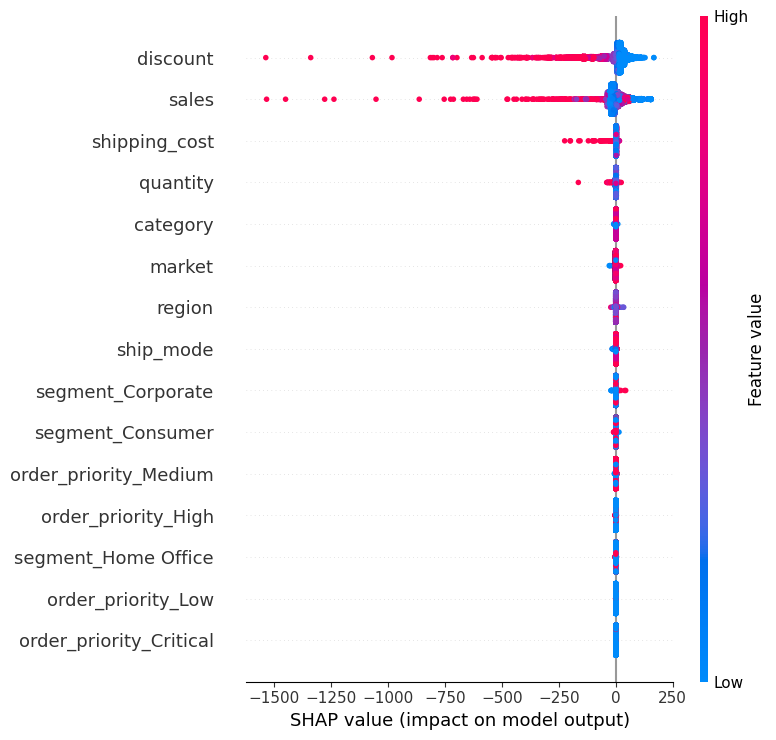

In [209]:
shap_summary(model = model_c0.results["random_forest"]["best_model"], X_train=model_c0.X_train, X_test = model_c0.X_test)

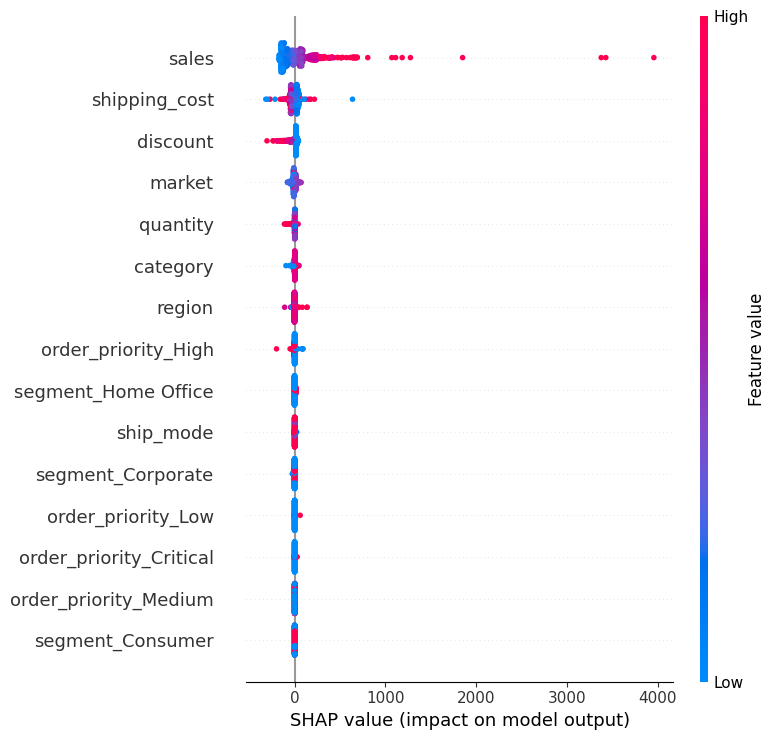

In [210]:
shap_summary(model = model_c1.results["gradient_boosting"]["best_model"], X_train=model_c1.X_train, X_test = model_c1.X_test)

Vemos que en ninguno de los clusters tiene mucha relevancia el segmento ni prioridad de pedido. Podemos repetir el proceso sin estas features y comprobar el cambio.

In [211]:
df_cluster0 = df_cluster0.drop(columns = df_cluster0.filter(like = "segment").columns).drop(columns = df_cluster0.filter(like = "order_priority").columns)

In [219]:
df_cluster1 = df_cluster1.drop(columns = df_cluster1.filter(like = "segment").columns).drop(columns = df_cluster1.filter(like = "order_priority").columns)

In [220]:
model_c0 = RegressionModel(X = df_cluster0.drop(columns = "profit"), y = df_cluster0["profit"])
model_c1 = RegressionModel(X = df_cluster1.drop(columns = "profit"), y = df_cluster1["profit"])

In [221]:
params_random_forest = {
    "n_estimators": [70, 100],
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 4, 8]
}


params_gb = {
    'n_estimators': [50,70],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }

params_xgboost = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3]
}

params_decision_tree = {
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_leaf_nodes": [None, 10, 20, 50],
}


In [240]:
model_c0.train(model_type="random_forest", params=params_random_forest)
model_c0.train(model_type="gradient_boosting", params=params_gb, learning_rate=0.1)
model_c0.train(model_type="xgboost", params = params_xgboost, learning_rate=0.1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,R2,MAE,RMSE
Train,0.839072,23.623976,45.995911
Test,0.714632,25.075729,60.605467


In [222]:
model_c1.train(model_type="random_forest", params=params_random_forest)
model_c1.train(model_type="gradient_boosting", params=params_gb, learning_rate=0.1)
model_c1.train(model_type="xgboost", params = params_xgboost, learning_rate=0.1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,R2,MAE,RMSE
Train,0.688794,165.433172,233.266258
Test,0.368655,198.806793,426.918094


In [245]:
df_results_c0 = pd.DataFrame()
for k in model_c0.results.keys():
    df_result = model_c0.results[k]["metrics"]
    df_result["method"] = k
    df_results_c0 = pd.concat([df_results_c0, df_result])

df_results_c0

,R2,MAE,RMSE,method
Train,0.822562,23.820745,48.297832,random_forest
Test,0.780632,24.712413,53.136923,random_forest
Train,0.850677,23.489635,44.306492,gradient_boosting
Test,0.778693,24.756156,53.371235,gradient_boosting
Train,0.839072,23.623976,45.995911,xgboost
Test,0.714632,25.075729,60.605467,xgboost


En el caso del cluster 0, el modelo más óptimo es el random forest, el cual tiene el menor overfitting y las métricas más equilibradas de los 3 casos estudiados. Tenemos un RMSE bastante bajo, teniendo en cuenta que el rango de profit en este grupo es de 6958, lo cual representa un 0.7% de error.

In [243]:
df_results_c1 = pd.DataFrame()
for k in model_c1.results.keys():
    df_result = model_c1.results[k]["metrics"]
    df_result["method"] = k
    df_results_c1 = pd.concat([df_results_c1, df_result])

df_results_c1

,R2,MAE,RMSE,method
Train,0.673604,156.052867,238.891567,random_forest
Test,0.514081,191.697513,374.535403,random_forest
Train,0.725162,157.392946,219.213188,gradient_boosting
Test,0.612236,187.286322,334.575950,gradient_boosting
Train,0.688794,165.433172,233.266258,xgboost
Test,0.368655,198.806793,426.918094,xgboost


En cuanto al cluster 1, las métricas no son tan buenas como en el cluster 0. Aquí el mejor modelo resulta ser el gradient boosting, que presenta un leve overfitting, y un RMSE de alrededor de 275. El rango de profit en este conjunto es mayor, de unos 8852, por lo que tendríamos un 3% de error, que sigue siendo aceptable.

Podemos observar la influencia de cada una de las características en cada uno de los modelos con un plot SHAP:

 98%|===================| 14381/14742 [00:37<00:00]        

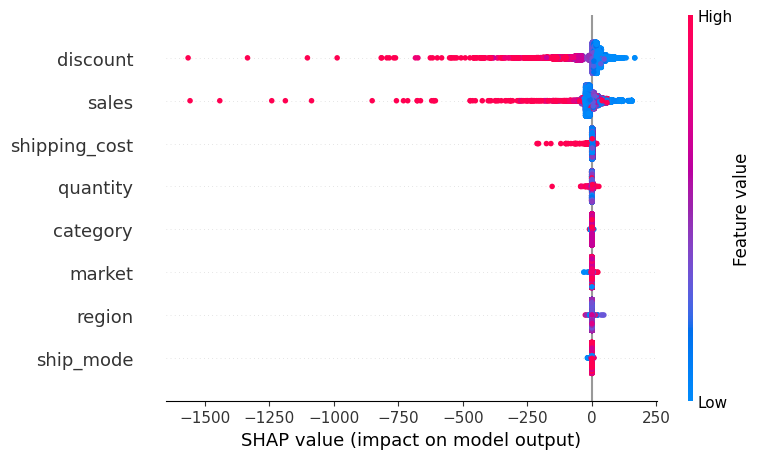

In [241]:
shap_summary(model = model_c0.results["random_forest"]["best_model"], X_train=model_c0.X_train, X_test = model_c0.X_test)

Vemos que para el cluster 0, donde los beneficios son bajos o incluso negativos, la prioridad debería ser reducir los descuentos, ya que es lo que más influye en los beneficios. Además, también se ve que ventas altas influyen también negativamente en el profit, lo que indica que los productos del cluster 0 (principalmente material de oficina), tiene márgenes muy bajos, por lo que mayores ventas indica menor beneficio. Los costos de envío también afectan a nuestro beneficio: a mayor costo menor beneficio, lo que indica una falta de optimización en la logística.

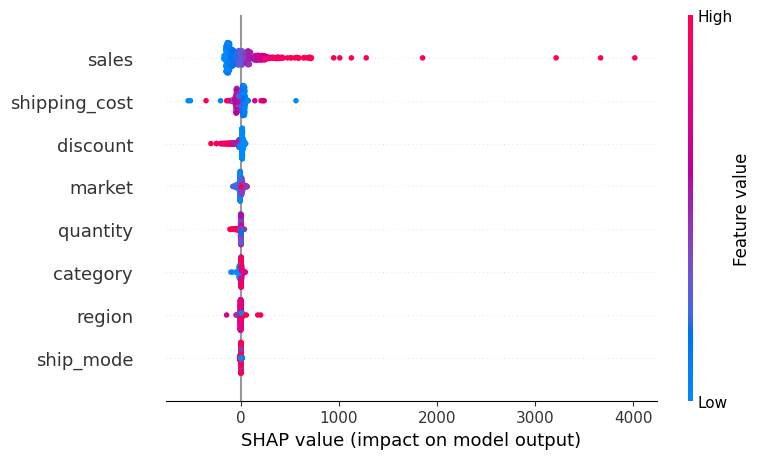

In [224]:
shap_summary(model = model_c1.results["gradient_boosting"]["best_model"], X_train=model_c1.X_train, X_test = model_c1.X_test)

En cuanto al cluster 1, vemos una gran diferencia comparado con el 0, ya que aquí a mayores ventas mayor es el beneficio. Esto se debe a los buenos márgenes que aportan los productos tecnológicos y los muebles. Además vemos que los costos de envío también influyen, aunque no es tan radical como las ventas, indicando que en este grupo la logística está bien optimizada. Por último, los descuentos también tienen un impacto negativo en nuestros beneficios, aunque comparado con el cluster 0 este es mucho menor, por lo que podrían estar incentivando ventas sin reducir el margen de manera significativa.